In [ ]:
pip install -q *.whl numpy matplotlib osparc_filecomms

In [1]:
import os
import pathlib as pl
import json
import zipfile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import osparc
import osparc.api
import osparc_client
import osparc_client.models.file

import tools.maps
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
osparc_cfg = osparc.Configuration(
        host="10.43.103.149.nip.io:8006",
        username=os.environ["OSPARC_API_KEY"],
        password=os.environ["OSPARC_API_SECRET"])
output_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_OUTPUTS'])
output1_dir_path = output_dir_path / 'output_1'

input_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_INPUTS'])
input1_dir_path = input_dir_path / 'input_1'

In [3]:
TEST_INPUT_FILES = ["model_seg_rat_axon-myelin_sem.png", "model_seg_rat_axon-myelin_sem.png"]

In [4]:
def show_input_files(file_list):
    for local_file_path in file_list:
        plt.imshow(mpimg.imread(local_file_path))
        plt.show()

In [5]:
def upload_files(file_list):
    uploaded_files = []
    with osparc.ApiClient(osparc_cfg) as api_client:
        for local_file_path in file_list:
            uploaded_file = osparc.api.FilesApi(api_client).upload_file(                                                                                                                                                                    
                file=pl.Path(local_file_path)                                                                                                                                                                                                       
            )
            uploaded_files.append(uploaded_file)
    return uploaded_files

In [6]:
def create_map_inputs(up_file_list):
    map_inputs = []
    for uploaded_file in up_file_list:
        map_inputs.append({
            "input": { 
                "InputImage": {
                    "type": "file",
                    "value": json.dumps(uploaded_file.to_dict())
                }
            },
            "output": {
                "Morphometrics": {
                  "type": "file"
                },
                "ProcessedImage": {
                  "type": "file"
                }
            }
        })
    return map_inputs

In [7]:
def read_map_outputs(map_outputs):
    processed_outputs = []
    with osparc.ApiClient(osparc_cfg) as api_client:
        for map_output in map_outputs:
            processed_output = {}
            for probe_name, probe_dict in map_output.items():
                file_dict = json.loads(probe_dict["value"])
                osparc_file = osparc_client.models.file.File(**file_dict)
                processed_output[probe_name]= osparc.api.FilesApi(api_client).download_file(osparc_file.id)
    
            processed_outputs.append(processed_output)
    return processed_outputs

In [8]:
uploaded_files = upload_files(TEST_INPUT_FILES)

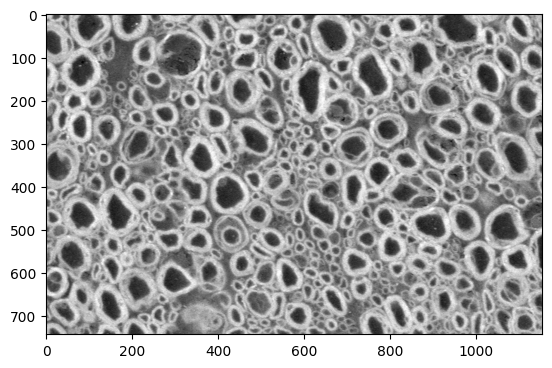

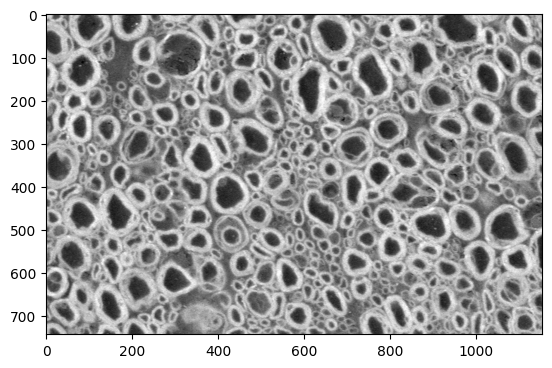

In [9]:
show_input_files(TEST_INPUT_FILES)
map_inputs = create_map_inputs(uploaded_files)

In [10]:
map = tools.maps.oSparcFileMap(input1_dir_path/'output_tasks.json', output1_dir_path/'input_tasks.json')

INFO:osparc_filecomms.handshakers:Wrote handshake confirmation to outputs/output_1/handshake.json


INFO:osparc_filecomms.handshakers:Waiting for registration confirmation...


In [11]:
map_outputs = read_map_outputs(map.evaluate(map_inputs))
print(map_outputs)

[{'Morphometrics': '/tmp/tmpusdcdsiv', 'ProcessedImage': '/tmp/tmpgdicwszd'}, {'Morphometrics': '/tmp/tmpf75_j_dm', 'ProcessedImage': '/tmp/tmpcto5q1f5'}]


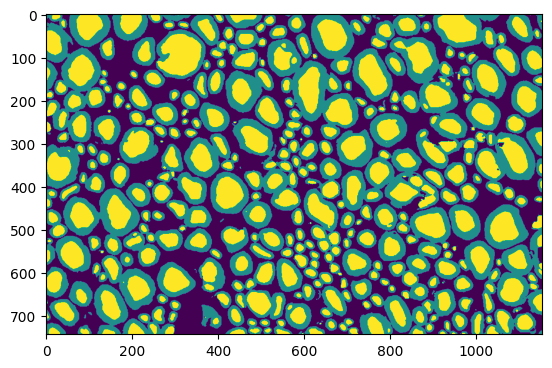

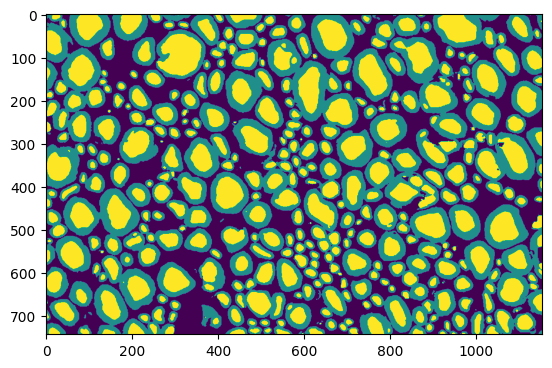

In [12]:
for map_output in map_outputs:
    with zipfile.ZipFile(map_output['ProcessedImage']) as output_zip:
        with output_zip.open('model_seg_rat_axon-myelin_sem_seg-axonmyelin.png') as image_file:
            plt.imshow(mpimg.imread(image_file))
            plt.show()